In [291]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import MultiComparison
import matplotlib.pyplot as plt
from scipy import stats

ANOVA test is used to find out whether there is any significant difference between testing groups, normally 3 or more. One-way ANOVA involves one measurement and one categorical variable with multiple levels, for example height and sex, to tell whether the levels (or groups, in this case, the sex) are significantly different from each other. Two-way ANOVA involves 1 measurent or dependant variable (DV) and 2 categorical variable or independant variables (IV), for example sex and country.

In other words, two-way ANOVA gives more information to us to find out whether the groups are really different, by taking into account of new variable. For example, in a One-way ANOVA test on a sample, we found out that there's no significant difference in height between different sex, but when we introduced another variable and do two-way ANOVA this time, we found out that it's not necessarily true, because while there is no significant difference in height between Male and Female of UK and Australia, it exists for Singaporeans, so the two groups are indeed different after all. We say "Country" is the blocking variable here. We can flip it the other way to test for significant difference between Country groups and now "Sex" is the blocking variable here. 

Well will there be a 3-way, 4 way ANOVA? Well techically it can exists, but technically challenging to calculate. Besides, we can use regression to make the same inference and technically, linear regression is an extension/related to ANOVA. Why is it challenging? Because in ANOVA more than 1 way, we will calculate main effect and interaction effect.

# Table of Contents

## 1. Practical coding and analyze the result
## 2. The intuition - Dive deeper into simple math
## 3. Discover new concepts in ANOVA

In [399]:
def generate_data(seed=2):
    np.random.seed(seed)
    Age_group_A = np.random.normal(108, 18.9, 30)
    Age_group_B = np.random.normal(110, 19.2, 30)
    Age_group_C = np.random.normal(112, 19.0, 30)
    
    data = pd.DataFrame({'Age_group_A': Age_group_A, 'Age_group_B': Age_group_B, 'Age_group_C': Age_group_C})

    data['Country'] = None
    data = data.sort_values('Age_group_A')
    data.iloc[:10,3] = 'UK'
    data.iloc[10:20,3] = 'US'
    data.iloc[20:,3] = 'SG'

    # To make sure the score distribution in Age group really varies by country
#     Age_group_B = data.Age_group_B.sort_values().values
#     data.loc[data.Country=='UK', 'Age_group_B'] = Age_group_B[20:]
#     data.loc[data.Country=='US', 'Age_group_B'] = Age_group_B[10:20]
#     data.loc[data.Country=='SG', 'Age_group_B'] = Age_group_B[:10]

#     Age_group_C = data.Age_group_C.sort_values().values
#     data.loc[data.Country=='UK', 'Age_group_C'] = Age_group_C[10:20]
#     data.loc[data.Country=='US', 'Age_group_C'] = Age_group_C[:10]
#     data.loc[data.Country=='SG', 'Age_group_C'] = Age_group_C[20:]

    return data.melt(id_vars='Country', var_name='Age_group', value_name='Score')
    
def summary(data, groupby, value):
    return data.groupby(groupby)[value].agg(['count','mean','std'])

def print_results_extra(anova_lm_results):
    anova_lm_results['eta_sq'] = 'NaN'
    anova_lm_results['eta_sq'] = anova_lm_results[:-1]['sum_sq']/sum(anova_lm_results['sum_sq'])

    mse = anova_lm_results['sum_sq'][-1]/anova_lm_results['df'][-1]
    anova_lm_results['omega_sq'] = 'NaN'
    anova_lm_results['omega_sq'] = (anova_lm_results[:-1]['sum_sq']-(anova_lm_results[:-1]['df']*mse))/(sum(anova_lm_results['sum_sq'])+mse)
    
    print(anova_lm_results.round(4))

# 1. Practical coding and analyze the result

## 1.1 Obtain and analyze ANOVA test results

In this section we'll quickly perform two-way ANOVA test and then analyze the results comprehensively. The purpose is to understand how to effectively and practically use two-way ANOVA. Of course, as you progress to next sections, I'll reveal other important things and concepts that you should also NOT forget. But let's go step-by-step.

First, we are going to generate some data. Supposed we collect `Score` data from some international test like SAT. We have 2 independant categorical variables here, namely `Country` and `Gene` and we are going to perform a two-way ANOVA.

So what are we trying to do here is to see, whether `Country` and `Gene` affect `Score`.

In [400]:
data = generate_data(2)
summary(data, ['Country','Age_group'], 'Score')

count        mean        std
Country Age_group                                
SG      Age_group_A     10  121.208980  14.580748
        Age_group_B     10  112.002611  16.953629
        Age_group_C     10  101.355464  21.767009
UK      Age_group_A     10   83.929864   7.678484
        Age_group_B     10  111.949602  21.492482
        Age_group_C     10  111.280578  20.358198
US      Age_group_A     10  100.097167   5.183349
        Age_group_B     10  111.909675  23.450453
        Age_group_C     10  115.090751  16.760120

In [401]:
formula = 'Score ~ C(Age_group)*C(Country)'
model = ols(formula, data).fit()
results = anova_lm(model, typ=2)
print_results_extra(results)

                             sum_sq    df       F  PR(>F)  eta_sq  omega_sq
C(Age_group)              1677.7326   2.0  2.7287  0.0713  0.0485    0.0305
C(Country)                1338.2701   2.0  2.1766  0.1200  0.0387    0.0207
C(Age_group):C(Country)   6656.7941   4.0  5.4133  0.0006  0.1925    0.1556
Residual                 24901.7490  81.0     NaN     NaN     NaN       NaN


### A. Interpreting the results
In two-way ANOVA, the first thing we must check is the interaction effect, in this case the combined effect of `Age_group` and `Country`. To do that we use the formula `C(Age_group)*C(Country)` to auto-generate the main effect (individual effect by each variable) and the interaction effect. This is equivalent to `C(Age_group) + C(Country) + C(Age_group):C(Country)`. If interaction effect is present, work is done - it's not meaningful to access individual effect anymore!

**From the results, it seems that:**
1. `Score` is driven by the interaction effect `C(Age_group):C(Country)`. The p-value of `C(Age_group):C(Country)` is significant. We can conclude that the `Score` is driven by the combined effect of both variables, regardless of whether the p-values of individual variable is significant or not. Work is done!

### B. Great discovery

Well this is a great discovery! Supposed we have initially only collected `Score` and `Age_group` data. **To our disappointment, `Age_group` can't predict the outcome.**

In [402]:
formula = 'Score ~ C(Age_group)'
model = ols(formula, data).fit()
results = anova_lm(model, typ=2)
print_results_extra(results)

                  sum_sq    df       F  PR(>F)  eta_sq  omega_sq
C(Age_group)   1677.7326   2.0  2.2185  0.1149  0.0485    0.0264
Residual      32896.8132  87.0     NaN     NaN     NaN       NaN


Imagined somewhere on earth another research competitor is also collecting these data, but instead of `Age_group`, they believe in using `Country`. **Another disappointment occurred to the world:**

In [403]:
formula = 'Score ~ C(Country)'
model = ols(formula, data).fit()
results = anova_lm(model, typ=2)
print_results_extra(results)

                sum_sq    df       F  PR(>F)  eta_sq  omega_sq
C(Country)   1338.2701   2.0  1.7515  0.1796  0.0387    0.0164
Residual    33236.2757  87.0     NaN     NaN     NaN       NaN


After that initial test, we thought maybe `Country` could provide more information. And we are right!

In [404]:
formula = 'Score ~ C(Age_group)*C(Country)'
model = ols(formula, data).fit()
results = anova_lm(model, typ=2)
print_results_extra(results)

                             sum_sq    df       F  PR(>F)  eta_sq  omega_sq
C(Age_group)              1677.7326   2.0  2.7287  0.0713  0.0485    0.0305
C(Country)                1338.2701   2.0  2.1766  0.1200  0.0387    0.0207
C(Age_group):C(Country)   6656.7941   4.0  5.4133  0.0006  0.1925    0.1556
Residual                 24901.7490  81.0     NaN     NaN     NaN       NaN


So the final predictor should be as below. And we can conclude that `Score` are significantly different between each sub-group. 

In [405]:
formula = 'Score ~ C(Age_group):C(Country)'
model = ols(formula, data).fit()
results = anova_lm(model, typ=2)
print_results_extra(results)

                             sum_sq    df       F  PR(>F)  eta_sq  omega_sq
C(Age_group):C(Country)   9672.7968   8.0  3.9329  0.0006  0.2798    0.2068
Residual                 24901.7490  81.0     NaN     NaN     NaN       NaN


Of course, A picture tells a thousand words. **Estimated Marginal Means graph** tells a good story and one can use this even before doing ANOVA test to get a rough sense of what to expect. How to interpret?

1. Each line represents an Age_group, each column represents a Country. If the lines cross over or "are going to" cross over, then interaction effect is present.

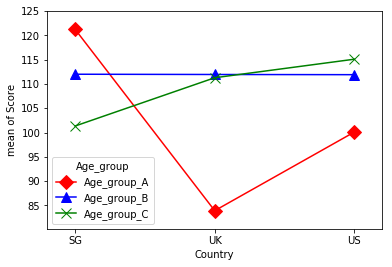

In [406]:
fig = interaction_plot(data.Country, data.Age_group, data.Score, colors=['red','blue','green'], markers=['D','^','x'], ms=10)

### C. Effect size

ANOVA and its p-value only tell us whether an effect (variable) is significant or not, but do not quantify the effect, whether is large or small. These are [several common effect size measures, their intuition and calculation](https://www.theanalysisfactor.com/effect-size).

See also the math in the "2. The Intuition - Dive Deep into Simple Math" section.

### D. Post-hoc testing

So which pair of groups or subgroups are different from each other? We turn to [Tukey HSD](https://sciencing.com/what-is-the-tukey-hsd-test-12751748.html) - Multiple comparison of means for post-hoc testing to find out. This is a post-ANOVA testing. **We can see that UK group A is really different from 5 other groups!**

ANOVA only tells you whether there is any difference between the groups as a bunch but does not tell you which pair is different. As long as there is a odd pair, ANOVA will just tell you "there is difference between groups, but I don't know which specifically"

In [321]:
data['subgroup'] = data.Country + '_' + data.Age_group

In [322]:
mc = MultiComparison(data['Score'], data['subgroup'])
mc_results = mc.tukeyhsd()
print(mc_results)

       Multiple Comparison of Means - Tukey HSD,FWER=0.05      
    group1         group2     meandiff  lower    upper   reject
---------------------------------------------------------------
SG_Age_group_A SG_Age_group_B -9.2064  -34.1968 15.7841  False 
SG_Age_group_A SG_Age_group_C -19.8535 -44.844   5.1369  False 
SG_Age_group_A UK_Age_group_A -37.2791 -62.2696 -12.2887  True 
SG_Age_group_A UK_Age_group_B -9.2594  -34.2498 15.7311  False 
SG_Age_group_A UK_Age_group_C -9.9284  -34.9189  15.062  False 
SG_Age_group_A US_Age_group_A -21.1118 -46.1023  3.8786  False 
SG_Age_group_A US_Age_group_B -9.2993  -34.2898 15.6911  False 
SG_Age_group_A US_Age_group_C -6.1182  -31.1087 18.8722  False 
SG_Age_group_B SG_Age_group_C -10.6471 -35.6376 14.3433  False 
SG_Age_group_B UK_Age_group_A -28.0727 -53.0632 -3.0823   True 
SG_Age_group_B UK_Age_group_B  -0.053  -25.0435 24.9374  False 
SG_Age_group_B UK_Age_group_C  -0.722  -25.7125 24.2684  False 
SG_Age_group_B US_Age_group_A -11.9054 -

Let's try to make sense by looking at the summary below.

In [323]:
summary(data, ['Country','Age_group'], 'Score')

count        mean        std
Country Age_group                                
SG      Age_group_A     10  121.208980  14.580748
        Age_group_B     10  112.002611  16.953629
        Age_group_C     10  101.355464  21.767009
UK      Age_group_A     10   83.929864   7.678484
        Age_group_B     10  111.949602  21.492482
        Age_group_C     10  111.280578  20.358198
US      Age_group_A     10  100.097167   5.183349
        Age_group_B     10  111.909675  23.450453
        Age_group_C     10  115.090751  16.760120

But when we look at the average score by individual varible, they don't look significantly different by groups - at least as informed by statistics!

In [324]:
print(summary(data, ['Country'], 'Score'))
print(summary(data, ['Age_group'], 'Score'))

         count        mean        std
Country                              
SG          30  111.522352  19.243188
UK          30  102.386681  21.599911
US          30  109.032531  17.584711
             count        mean        std
Age_group                                
Age_group_A     30  101.745337  18.265503
Age_group_B     30  111.953963  20.080466
Age_group_C     30  109.242264  19.937883


### E. A Different Story

Let's look at a totally different story with different data. Your turn - what can you tell?

In [325]:
data = generate_data(3)

formula = 'Score ~ C(Age_group)*C(Country)'
model = ols(formula, data).fit()
results = anova_lm(model, typ=2)
print_results_extra(results)

print('n')
formula = 'Score ~ C(Country)'
model = ols(formula, data).fit()
results = anova_lm(model, typ=2)
print_results_extra(results)

print('n')
formula = 'Score ~ C(Age_group)'
model = ols(formula, data).fit()
results = anova_lm(model, typ=2)
print_results_extra(results)

                             sum_sq    df       F  PR(>F)  eta_sq  omega_sq
C(Age_group)              1930.6826   2.0  2.7408  0.0705  0.0495    0.0311
C(Country)                5183.3487   2.0  7.3583  0.0012  0.1328    0.1137
C(Age_group):C(Country)   3397.4713   4.0  2.4115  0.0557  0.0870    0.0505
Residual                 28529.0986  81.0     NaN     NaN     NaN       NaN
n
                sum_sq    df       F  PR(>F)  eta_sq  omega_sq
C(Country)   5183.3487   2.0  6.6596   0.002  0.1328    0.1117
Residual    33857.2526  87.0     NaN     NaN     NaN       NaN
n
                  sum_sq    df       F  PR(>F)  eta_sq  omega_sq
C(Age_group)   1930.6826   2.0  2.2631  0.1101  0.0495    0.0273
Residual      37109.9186  87.0     NaN     NaN     NaN       NaN


In [326]:
mc = MultiComparison(data['Score'], data['Country'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  SG     UK   -17.9061 -30.052  -5.7602  True 
  SG     US   -13.2769 -25.4228  -1.131  True 
  UK     US    4.6293  -7.5166  16.7752 False 
----------------------------------------------


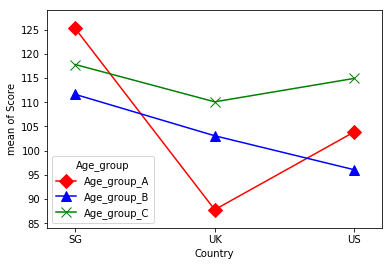

In [327]:
fig = interaction_plot(data.Country, data.Age_group, data.Score, colors=['red','blue','green'], markers=['D','^','x'], ms=10)

In [331]:
print(summary(data, ['Country'], 'Score'))
print(summary(data, ['Age_group'], 'Score'))
print(summary(data, ['Country','Age_group'], 'Score'))

         count        mean        std
Country                              
SG          30  118.229036  20.217547
UK          30  100.322903  21.419670
US          30  104.952172  17.318776
             count        mean        std
Age_group                                
Age_group_A     30  105.639352  17.479782
Age_group_B     30  103.587909  22.954946
Age_group_C     30  114.276850  21.146632
                     count        mean        std
Country Age_group                                
SG      Age_group_A     10  125.251214  11.217282
        Age_group_B     10  111.630965  26.979380
        Age_group_C     10  117.804930  18.973792
UK      Age_group_A     10   87.799823   8.023792
        Age_group_B     10  103.076542  18.620719
        Age_group_C     10  110.092344  27.902078
US      Age_group_A     10  103.867019   3.139563
        Age_group_B     10   96.056220  22.092249
        Age_group_C     10  114.933277  16.389569


## 1.2 Important things to check

ANOVA made few assumptions about the data. If any of these assumptions is violated, then the results may be inaccurate. IN the previous section, we have checked that the assumptions are valid.

In [333]:
data = generate_data(2)
summary(data, ['Country','Age_group'], 'Score')
formula = 'Score ~ C(Age_group)*C(Country)'
model = ols(formula, data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     3.933
Date:                Sat, 31 Aug 2019   Prob (F-statistic):           0.000572
Time:                        17:13:32   Log-Likelihood:                -380.73
No. Observations:                  90   AIC:                             779.5
Df Residuals:                      81   BIC:                             802.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      121.2090      5.545     21.861      0.000     110.177     132.241
C(Age_group)[T.Age_group_B]                     -9.2064      7.841     -1.174      0.244     -24.808       6.395
C(Age_group)[T.Age_group_C]                    -19.8535      7.841     -2.532      0.013     -35.455      -4.252
C(Country)[T.UK]                               -37.2791      7.841     -4.754      0.000     -52.881     -21.677
C(Country)[T.US]                               -21.1118      7.841     -2.692      0.009     -36.714      -5.510
C(Age_group)[T.Age_group_B]:C(Country)[T.UK]    37.2261     11.089      3.357      0.001      15.162      59.290
C(Age_group)[T.Age_group_C]:C(Country)[T.UK]    47.2042     11.089      4.257      0.000      25.140      69.268
C(Age_group)[T.Age_group_B]:C(Country)[T.US]    21.0189     11.089      1.895      0.062      -1.045      43.083
C(Age_group)[T.Age_group_C]:C(Country)[T.US]    34.8471     11.089      3.142      0.002      12.783      56.911
==============================================================================
Omnibus:                        4.137   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                3.517
Skew:                          -0.355   Prob(JB):                        0.172
Kurtosis:                       3.659   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Checking for assumptions

1. Omnibus - the assumption of [homogeneity of variance](https://www.statisticssolutions.com/the-assumption-of-homogeneity-of-variance/) (similar variance across groups). [Levene's test](https://www.statisticshowto.datasciencecentral.com/levene-test/) is more widely used.
2. [Jarque-Bera](https://www.statisticshowto.datasciencecentral.com/jarque-bera-test/) - test for normality within each cell. Each cell (Age_group-Country subgroup) is assumed to be generated from a Normal distribution. ANOVA, like many other statistical tests works with Normally distributed data. [Jarque-Bera may be inaccurate with small sample](https://davegiles.blogspot.com/2014/04/more-on-limitations-of-jarque-bera-test.html), so [Shapiro-Wilk Test](https://www.statisticshowto.datasciencecentral.com/shapiro-wilk-test/) may be better but it loses accuracy with sample>2000. More on [normality test](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/).
3. Condition number - test for multicollinearity between the independant variables. When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30. In this case we are well below 30, which we would expect given our model only has two variables and one is a constant.
4. [Durban Watson test](https://www.statisticshowto.datasciencecentral.com/durbin-watson-test-coefficient/) - test for presence of [autocorrelation](https://www.statisticshowto.datasciencecentral.com/serial-correlation-autocorrelation/). Here I'm not sure what's the importance and this is more commonly used for time series data. This test is rarely used as it is considered archaic.

### More......
**Let's look at each of the values listed:**

**Omnibus/Prob(Omnibus)** – a test of the skewness and kurtosis of the residual (characteristic #2). We hope to see a value close to zero which would indicate normalcy. The Prob (Omnibus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something close to 1 here. In this case Omnibus is relatively low and the Prob (Omnibus) is relatively high so the data is somewhat normal, but not altogether ideal. A linear regression approach would probably be better than random guessing but likely not as good as a nonlinear approach.

**Skew** – a measure of data symmetry. We want to see something close to zero, indicating the residual distribution is normal. Note that this value also drives the Omnibus. This result has a small, and therefore good, skew.

**Kurtosis** – a measure of "peakiness", or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers.

**Durbin-Watson** – tests for homoscedasticity (characteristic #3). We hope to have a value between 1 and 2. In this case, the data is close, but within limits.

**Jarque-Bera (JB)/Prob(JB)** – like the Omnibus test in that it tests both skew and kurtosis. We hope to see in this test a confirmation of the Omnibus test. In this case we do.

**Condition Number** – This test measures the sensitivity of a function's output as compared to its input (characteristic #4). When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30. In this case we are well below 30, which we would expect given our model only has two variables and one is a constant.

**In looking at the data we see an "OK" (though not great) set of characteristics. This would indicate that the OLS approach has some validity, but we can probably do better with a nonlinear model.**

**Data "Science" is somewhat of a misnomer because there is a great deal of "art" involved in creating the right model. Understanding how your data "behaves" is a solid first step in that direction and can often make the difference between a good model and a much better one.**

Reference: [Link](https://www.accelebrate.com/blog/interpreting-results-from-linear-regression-is-the-data-appropriate)

Normality of the data can also be visually performed with Q-Q or normal probability plot.

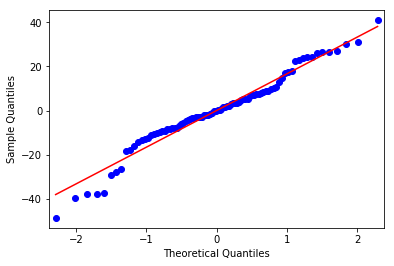

In [335]:
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

# 2. The Intuition - Dive Deeper into Simple Math
## 2.1 One-way ANOVA

First, understand the intuition behind One-way ANOVA. The key concept here is variation or variance. We detect how different each group is by looking at whether the variation is big or small enough. Why I have to reinvent the wheel here, when someone has already explained it well?

Youtube guide:
1. [One-way ANOVA, A Visual Tutorial](https://www.youtube.com/watch?v=JgMFhKi6f6Y)
2. [One-way ANOVA, the calculation](https://www.youtube.com/watch?v=UrRYITjDOww&t=1201s)


**Calculation goal: <br>**
Get the F statistics<br>
= MSE(accounted by the groups) / MSE(within groups)<br>
= variation explained by having different groups / unexplained variation
    
Steps:
1. Calculate degrees of freedom
2. Calculate sum of squares errors or variation
3. Calculate mean square errors, equivalent to variance (precisely, it is an estimate of population variance)
4. Calculate F statistics and p-value

In [386]:
data = generate_data(2)
formula = 'Score ~ C(Age_group)'
model = ols(formula, data).fit()
results = anova_lm(model, typ=1)
print_results_extra(results)

                df      sum_sq   mean_sq       F  PR(>F)  eta_sq  omega_sq
C(Age_group)   2.0   1677.7326  838.8663  2.2185  0.1149  0.0485    0.0264
Residual      87.0  32896.8132  378.1243     NaN     NaN     NaN       NaN


In [387]:
# Transform the data into readable format
Age_group_A = data.loc[data.Age_group=='Age_group_A', 'Score'].values
Age_group_B = data.loc[data.Age_group=='Age_group_B', 'Score'].values
Age_group_C = data.loc[data.Age_group=='Age_group_C', 'Score'].values
data = pd.DataFrame({'Age_group_A': Age_group_A, 'Age_group_B': Age_group_B, 'Age_group_C': Age_group_C})
data.head()

,Age_group_A,Age_group_B,Age_group_C
0,67.625894,63.252463,111.248165
1,74.104067,117.112535,73.233862
2,81.138994,114.149427,103.221898
3,84.464055,93.791097,84.650658
4,85.554128,119.761208,135.139827


In [388]:
# 1. Calculate degrees of freedom
# 2. Calculate sum of squares errors or variation
# 3. Calculate mean square errors, equivalent to variance (precisely, it is an estimate of population variance)
# 4. Calculate F statistics and p-value

k_col = len(data.columns)
N_col = data.shape[0]
N = N_col * data.shape[1]

# degree of freedom
df_col = k_col - 1
df_within = N - k_col

# sum of squares of columns and within
mean_grand  = data.values.mean()
mean_col    = data.mean()

ss_col    = np.sum( (mean_col - mean_grand) **2    ) * N_col # sum of squares of column mean from grand mean
ss_within = np.sum( (data - mean_col).values **2)  # sum of squares of data from column mean
mse_col    = ss_col/df_col
mse_within = ss_within/df_within

F = mse_col / mse_within
p = stats.f.sf(F, df_col, df_within)
F, p

(2.2184935580686522, 0.1148906045560028)

In [397]:
ss_total = np.sum( (data - mean_grand).values **2)
print(f'Total variation, ss_total is {ss_total}')
print(f'ss_col = {ss_col}')
print(f'ss_within = {ss_within}')
print(f'ss_col + ss_within = {ss_col + ss_within}')
print('\nSo total variation in the data is attributed to the variation accounted by having different groups and the natural variation/residual/unexplained variation in the data.')

Total variation, ss_total is 34574.545781207045
ss_col = 1677.7326005139216
ss_within = 32896.81318069311
ss_col + ss_within = 34574.54578120703

So total variation in the data is attributed to the variation accounted by having different groups and the natural variation/residual/unexplained variation in the data.


In [408]:
eta_squared = ss_col / ss_total
omega_squared = (ss_col - (df_col * mse_within))/(ss_total + mse_within)

eta_squared, omega_squared

(0.048525080014958616, 0.026363766195402785)

## 2.2 Two-way ANOVA

# 3. Discover New Concepts in ANOVA

In two-way ANOVA, there are such concepts which are important to know:

1. [Two-way ANOVA w/o Replication](https://www.youtube.com/watch?v=xNQliU8yiYk) - For this, we can't test for interaction effect
2. [Two-way ANOVA w/ Replication - Interaction](https://www.youtube.com/watch?v=g40D30YR6Fg&t=356s)
3. Balanced design

**Concept of balanced design**

Taking the previous example, if each group has different sample size, then `ss_within` is calculated by simply adding up SSE within each of the individual group. Balanced design means having same or not significantly different sample size within each group. It has important implication, as discussed [here](https://www.statisticssolutions.com/the-assumption-of-homogeneity-of-variance/).
<br>
<img width='600px' align='left' src='https://github.com/jasonlcy91/statistical-inference-and-thinking/blob/master/Images/ANOVA%20-%20Homogeneity%20of%20Variance.png?raw=true'>

In [410]:
data = generate_data(2)

# Transform the data into readable format
Age_group_A = data.loc[data.Age_group=='Age_group_A', 'Score'].values
Age_group_B = data.loc[data.Age_group=='Age_group_B', 'Score'].values
Age_group_C = data.loc[data.Age_group=='Age_group_C', 'Score'].values
data = pd.DataFrame({'Age_group_A': Age_group_A, 'Age_group_B': Age_group_B, 'Age_group_C': Age_group_C})

In [413]:
ss_within_Age_group_A = np.sum( (data.Age_group_A - data.Age_group_A.mean())**2 )
ss_within_Age_group_B = np.sum( (data.Age_group_B - data.Age_group_B.mean())**2 )
ss_within_Age_group_C = np.sum( (data.Age_group_C - data.Age_group_C.mean())**2 )
ss_within = ss_within_Age_group_A + ss_within_Age_group_B + ss_within_Age_group_C
ss_within

32896.813180693105

**More summary here:**

**With replication**<br>
When the sample sizes in each subgroup are equal (a "balanced design"), you calculate the mean square for each of the two factors (the "main effects"), for the interaction, and for the variation within each combination of factors. You then calculate each F-statistic by dividing a mean square by the within-subgroup mean square.

When the sample sizes for the subgroups are not equal (an "unbalanced design"), the analysis is much more complicated, and there are several different techniques for testing the main and interaction effects that I'm not going to cover here. If you're doing a two-way anova, your statistical life will be a lot easier if you make it a balanced design.

**Without replication**<br>
When there is only a single observation for each combination of the nominal variables, there are only two null hypotheses: that the means of observations grouped by one factor are the same, and that the means of observations grouped by the other factor are the same. It is impossible to test the null hypothesis of no interaction; instead, you have to assume that there is no interaction in order to test the two main effects.

When there is no replication, you calculate the mean square for each of the two main effects, and you also calculate a total mean square by considering all of the observations as a single group. The remainder mean square (also called the discrepance or error mean square) is found by subtracting the two main effect mean squares from the total mean square. The F-statistic for a main effect is the main effect mean square divided by the remainder mean square.

**Assumptions**<br>
Two-way anova, like all anovas, assumes that the observations within each cell are normally distributed and have equal standard deviations. I don't know how sensitive it is to violations of these assumptions.

# End, Thank you!

Some references:
1. https://www.youtube.com/watch?v=i4mamuL_CF8
2. https://reneshbedre.github.io/blog/anova.html
3. https://pythonfordatascience.org/anova-2-way-n-way/
4. https://www.statisticshowto.datasciencecentral.com/parametric-and-non-parametric-data/